This notebook: can we use the outputs of `to_cdr` to reproduce the epoched data / ERP results from the control?

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2eepch9_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
CDR_OUTPUT_DIR = Path("../work/c0/e17e6385700b9d22bdfce8b5d25eb5")
CDR_X = CDR_OUTPUT_DIR / "X.txt"
CDR_Y = CDR_OUTPUT_DIR / "y.txt"

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]

In [3]:
X = pd.read_csv(CDR_X, sep=" ", index_col="index")

In [4]:
more = []
for (subject, item, word_idx), rows in X.groupby(["subject", "item", "word_idx"]):
    if len(rows) > 1:
        more.append(((subject, item, word_idx), rows))

In [5]:
more

# TODO work this out ..

[((6, 155, 4),
         subject  onset_time  word_idx  sentence_idx  subject_idx  \
  index                                                             
  1561         6    1750.260         4           155            6   
  1572         6    2570.836         4           155            6   
  
         presentation_idx  index.1 word  surprisal  word_len  item      time  
  index                                                                       
  1561              147.0   1289.0   at   4.369451       2.0   155  1750.260  
  1572              147.0   1289.0   at   4.369451       2.0   155  2570.836  ),
 ((6, 155, 5),
         subject  onset_time  word_idx  sentence_idx  subject_idx  \
  index                                                             
  1562         6    1750.928         5           155            6   
  1573         6    2571.536         5           155            6   
  
         presentation_idx  index.1   word  surprisal  word_len  item      time  
  index      

In [6]:
y = pd.read_csv(CDR_Y, sep=" ", index_col=None).set_index(["subject", "item"])

In [7]:
# Zero out clock at the start of each item.
item_times = pd.DataFrame(X.groupby(["subject", "item"]).time.min())
item_times["y_time"] = y.groupby(["subject", "item"]).time.min()
item_times["min_time"] = item_times.min(axis=1)
X.time -= X.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time
y.time -= y.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time

In [8]:
X

,subject,onset_time,word_idx,sentence_idx,subject_idx,presentation_idx,index.1,word,surprisal,word_len,item,time
index,,,,,,,,,,,,
2,1,10.496,1,105,1,141.0,763.0,heaved,11.617825,6.0,105,0.772
3,1,11.236,2,105,1,141.0,764.0,his,2.238698,3.0,105,1.512
4,1,11.924,3,105,1,141.0,765.0,shoulders,3.669254,9.0,105,2.200
5,1,12.720,4,105,1,141.0,766.0,and,2.636277,3.0,105,2.996
6,1,13.408,5,105,1,141.0,767.0,swung,6.354124,5.0,105,3.684
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,24,1991.376,1,4,24,107.0,17.0,don't,3.693228,5.0,4,0.740
2132,24,1992.104,2,4,24,107.0,18.0,want,0.311405,4.0,4,1.468
2133,24,1992.804,3,4,24,107.0,19.0,to,2.853559,2.0,4,2.168


In [9]:
y

run_sample_id   time      VEOG     HEOG       50       36  \
subject item                                                              
1       105            2431  0.000 -148.4118 -58.7902 -49.5211 -57.4659   
        105            2432  0.004 -146.3327 -57.1931 -48.4107 -56.5921   
        105            2433  0.008 -143.7115 -55.6574 -47.6052 -55.9000   
        105            2434  0.012 -141.3364 -54.3678 -47.1676 -55.5744   
        105            2435  0.016 -139.3305 -53.4474 -47.0991 -55.4977   
...                     ...    ...       ...      ...      ...      ...   
24      4            498769  4.440  246.4211  66.4324  18.2847   2.6632   
        4            498770  4.444  244.9089  67.8759  23.3600   3.8559   
        4            498771  4.448  242.5139  68.0625  28.0530   7.0173   
        4            498772  4.452  239.6776  67.4338  31.1784  11.5971   
        4            498773  4.456  238.6845  66.3069  31.8009  16.1774   

                   49       37       48       38  ...      29       26  \
subject item                                      ...                    
1       105  -29.4307 -22.5573 -12.6038 -16.3979  ... -6.8055  -2.9148   
        105  -28.6867 -22.1875 -12.2427 -15.9065  ... -5.7878  -2.0443   
        105  -28.2478 -22.3707 -11.9430 -15.5995  ... -5.0604  -1.7192   
        105  -28.0552 -23.1688 -11.8894 -15.4156  ... -4.8083  -1.8824   
        105  -28.3537 -24.2130 -11.9573 -15.4778  ... -4.8107  -2.2937   
...               ...      ...      ...      ...  ...     ...      ...   
24      4     21.2028   9.8076  31.2651  10.3017  ...  5.8521  25.7481   
        4     21.8969  14.0362  29.6683  15.2857  ...  5.6808  27.6854   
        4     22.9615  16.4979  27.6970  19.3869  ...  5.6312  29.2362   
        4     23.9608  16.8764  25.7927  22.0370  ...  5.9214  30.4698   
        4     24.9607  14.7293  24.6514  22.6679  ...  6.7702  31.2076   

                   18       10       16       12       14        1       35  \
subject item                                                                  
1       105  -15.5896 -23.7365   9.4192  -3.5627  -8.8197   2.1342 -76.0032   
        105  -14.7207 -22.3817   9.8231  -2.3298  -7.8411   3.1085 -74.6488   
        105  -13.9131 -21.3302  10.1657  -1.6439  -7.1724   3.8960 -73.4769   
        105  -13.3518 -20.7668  10.1430  -1.3256  -6.8742   4.1865 -72.6726   
        105  -13.0381 -20.4516  10.1084  -1.2551  -6.9452   4.2333 -72.2374   
...               ...      ...      ...      ...      ...      ...      ...   
24      4     13.0548  29.5998  21.4491  38.6056  21.1059  41.5105   2.3059   
        4     13.2520  31.7854  21.9150  40.2980  22.8133  43.3555   5.1130   
        4     12.8156  32.9641  22.3360  41.3568  24.5277  44.8321  11.3829   
        4     12.4363  33.4534  22.7945  41.7252  26.1821  46.1247  19.9429   
        4     12.0575  33.5709  23.3732  41.5956  27.9641  47.1606  28.7517   

                    8  
subject item           
1       105  -28.3331  
        105  -26.8574  
        105  -25.4430  
        105  -24.2748  
        105  -23.4757  
...               ...  
24      4     -7.8750  
        4     -6.9302  
        4     -6.8683  
        4     -7.2476  
        4     -7.6265  

[8473452 rows x 36 columns]

---

In [10]:
epoch_data = []

# DEV: Work with subset
X_tgt = X[X.subject.isin((1, 2))]
grouper = X_tgt.groupby(["subject", "item", "word_idx"])
for (subject, item, word_idx), rows in tqdm(grouper, total=grouper.ngroups):
    # TODO should always be 1 row.
    if len(rows) > 1:
        print(f"Warning: {len(rows)} rows for {(subject, item, word_idx)}.")
    x = rows.iloc[0]
    
    y_df = y.loc[subject].loc[item]
    
    epoch_left, epoch_right = EPOCH_WINDOW
    epoch_window = y_df[(y_df.time >= x.time + epoch_left) & (y_df.time <= x.time + epoch_right)]
    
    baseline_window = epoch_window[epoch_window.time <= x.time]
    
    test_left, test_right = TEST_WINDOW
    test_window = epoch_window[(epoch_window.time >= x.time + test_left) & (epoch_window.time <= x.time + test_right)]
    
    # subset electrodes
    baseline_window = baseline_window[N400_ELECTRODES]
    test_window = test_window[N400_ELECTRODES]
    
    # take means
    baseline_window = baseline_window.mean(axis=0)
    test_window = test_window.mean(axis=0)
    
    epoch_data.append((subject, item, x.word_idx, baseline_window.mean(), test_window.mean()))

  0%|          | 0/3478 [00:00<?, ?it/s]

In [32]:
epoch_df = pd.DataFrame(epoch_data, columns=["subject_idx", "sentence_idx", "word_idx", "cdr_base_N400", "cdr_value_N400"]) \
    .set_index(["subject_idx", "sentence_idx", "word_idx"])
epoch_df

cdr_base_N400  cdr_value_N400
subject_idx sentence_idx word_idx                               
1           1            1              0.055950       -0.096535
                         2              1.587728        1.430031
                         3              3.822657        5.169919
                         4              2.546415        3.031341
            2            0             -9.734279       -6.089987
...                                          ...             ...
2           205          7              5.598107        6.510460
                         8              6.490314       -0.197018
                         9             -4.858927       -6.280228
                         10            -6.062846      -14.811391
                         11           -18.669761      -11.371245

[3478 rows x 2 columns]

-----

In [33]:
REFERENCE_DATASET = Path("../output/frank2015/erp/erp_full.csv")
reference_df = pd.read_csv(REFERENCE_DATASET, index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  ...  \
subject_idx sentence_idx word_idx                                    ...   
1           1            0                3.145689         3.121044  ...   
                         1                8.214565         7.030273  ...   
                         2                8.330564         6.914139  ...   
                         3                3.210452         2.787990  ...   
                         4                8.541803         8.242652  ...   
...                                            ...              ...  ...   
24          205          7                3.924689         3.901125  ...   
                         8                7.945024         6.722867  ...   
                         9                9.959173         8.835783  ...   
                         10               3.884360         3.874658  ...   
                         11               8.574935         8.116138  ...   

                                   surp_rnn_size_6  surp_rnn_size_

---

## Compare with pre-packaged ERP data

From Frank et al 2015 dataset

In [34]:
comp_df = pd.merge(epoch_df, reference_df, how="left", left_index=True, right_index=True)
comp_df

cdr_base_N400  cdr_value_N400  value_N400  \
subject_idx sentence_idx word_idx                                              
1           1            1              0.055950       -0.096535   -1.859916   
                         2              1.587728        1.430031   -0.326976   
                         3              3.822657        5.169919    3.984934   
                         4              2.546415        3.031341    6.883699   
            2            0             -9.734279       -6.089987   -3.135751   
...                                          ...             ...         ...   
2           205          7              5.598107        6.510460    1.886418   
                         8              6.490314       -0.197018   -1.207221   
                         9             -4.858927       -6.280228   -2.208364   
                         10            -6.062846      -14.811391   -6.649468   
                         11           -18.669761      -11.371245   -3.098316   

                                   base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                
1           1            1         -2.745968         0       1   
                         2         -0.486989         0       0   
                         3          1.054487         0       0   
                         4          2.721698         0       1   
            2            0         -5.448901         0       1   
...                                      ...       ...     ...   
2           205          7          0.133771         0       0   
                         8          2.666967         1       1   
                         9         -4.288091         1       1   
                         10         0.072108         0       0   
                         11       -10.565768         1       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
            2            0                   8.624263            8.616918   
...                                               ...                 ...   
2           205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  ...  \
subject_idx sentence_idx word_idx                                       ...   
1           1            1                   5.292745         9.514440  ...   
                         2                   3.084290         9.111075  ...   
                         3                   0.676790         3.594287  ...   
                         4                   4.629370         8.459698  ...   
            2            0                   8.616918        10.814248  ...   
...                                               ...              ...  ...   
2           205          7                   4.245483         4.631127  ...   
                         8                   4.272032         8.139806  ...   
                         9                   6.910058        10.800107  ...   
                         10                  2.342811         4.568191  ...   
                         11                  1.327797         9.073960  ...   

                                   surp_rnn_size_6  surp_rnn_size_7  \
subject_idx sentence_idx word_idx 

<AxesSubplot:xlabel='cdr_value_N400', ylabel='value_N400'>

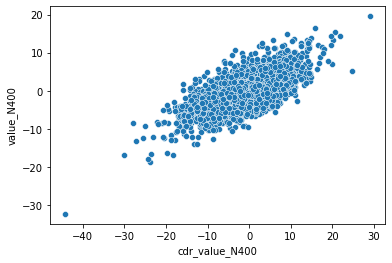

In [35]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="value_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='base_N400'>

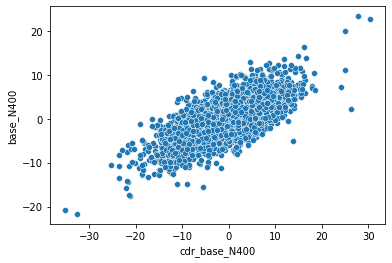

In [36]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="base_N400")

In [37]:
import scipy.stats

In [38]:
scipy.stats.pearsonr(comp_df.value_N400, comp_df.cdr_value_N400)

(0.7001215766458738, 0.0)

In [39]:
scipy.stats.pearsonr(comp_df.base_N400, comp_df.cdr_base_N400)

(0.7303530086976846, 0.0)

Just as before, it's not a perfect correlation -- there is preprocessing done in Frank et al., e.g. the modulus transformation, not done in our pipeline -- but things look pretty good.

---

## Compare with our own MNE-based ERP data

<AxesSubplot:xlabel='cdr_value_N400', ylabel='our_N400'>

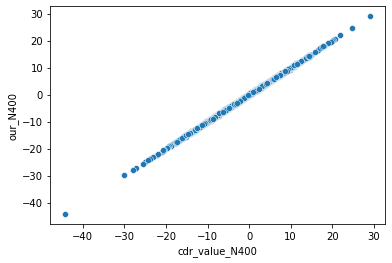

In [41]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="our_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='our_baseline'>

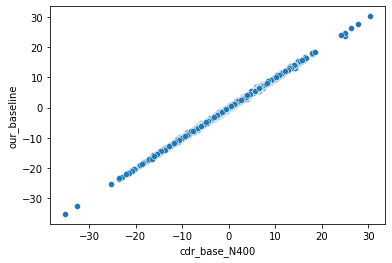

In [42]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="our_baseline")

In [43]:
scipy.stats.pearsonr(comp_df.cdr_value_N400, comp_df.our_N400)

(0.9998722060218763, 0.0)

In [44]:
scipy.stats.pearsonr(comp_df.cdr_base_N400, comp_df.our_baseline)

(0.9997169779428041, 0.0)

Perfect.